In this note, we numerically study the expansion of a surface code.
We first study the expansion without post-selection.

In [2]:
import numpy as np
import stim
import matplotlib.pyplot as plt
import pymatching
import sinter
from typing import List

In [123]:
class SurfaceCode:
    def __init__(self, m: int, n: int, error_rate: float = 0.001):
        self.m = m # Number of columns
        self.n = n # Number of rows
        self.error_rate = error_rate
        self.data_dict, self.data_list = self.generate_data_dict_and_list()
        self.check_list = self.generate_check_list(self.data_dict)
        self.total_qubit_number = 0
        # print(self.check_list)

    def generate_data_dict_and_list(self):
        """
        data_dict: (for finding index of a data qubit from position)
            key: position, 
            value: index,
        data_list: list of indices (for loop over data qubits)
        """
        data_dict = {}
        data_list = []
        idx = 0
        for i in range(self.m):
            for j in range(self.n):
                data_dict[(2 * i, 2 * j)] = idx
                data_list.append(idx)
                idx += 1
        return data_dict, data_list

    def generate_check_list(self, data_dict):
        """
        list of dicts: {
            'type': 'X' or 'Z',
            'pos': position,
            'idx': index,
            'data_qubits'; indices of data qubits to check
        }
        """
        check_list = []
        idx = self.m * self.n
        # X checks
        for i in range(0, self.m + 1, 2):
            for j in range(self.n - 1):
                pos = [2 * i - 1 + 2 * (j % 2), 2 * j + 1]
                if pos[0] <= 2 * self.m - 1:
                    check_list.append({
                        'type': 'X',
                        'pos': pos,
                        'idx': idx,
                        'data_qubits': [
                            data_dict.get((pos[0] - 1, pos[1] - 1)),
                            data_dict.get((pos[0] - 1, pos[1] + 1)),
                            data_dict.get((pos[0] + 1, pos[1] - 1)),
                            data_dict.get((pos[0] + 1, pos[1] + 1)),
                        ]
                    })
                    idx += 1
        # Z checks
        for i in range(self.m - 1):
            for j in range(0, self.n + 1, 2):
                pos = [2 * i + 1, 2 * j + 1 - 2 * (i % 2)]
                if pos[1] <= 2 * self.n - 1:
                    check_list.append({
                        'type': 'Z',
                        'pos': pos,
                        "idx": idx,
                        'data_qubits': [
                            data_dict.get((pos[0] - 1, pos[1] - 1)),
                            data_dict.get((pos[0] + 1, pos[1] - 1)),
                            data_dict.get((pos[0] - 1, pos[1] + 1)),
                            data_dict.get((pos[0] + 1, pos[1] + 1)),
                        ]
                    })
                    idx += 1
        return check_list

    def generate_circuit(self, rounds: int = 10, if_measure=True):
        self.total_qubit_number = len(self.data_list) + len(self.check_list)
        circuit = self.initialize_circuit_position()
        self.initialize_circuit(circuit)
        for t in range(rounds):
            self.syndrome_measurement(circuit, t)
        if if_measure:
            self.Z_measurement(circuit, rounds)
        return circuit

    def initialize_circuit_position(self):
        circuit = stim.Circuit()
        for pos in self.data_dict:
            circuit.append("QUBIT_COORDS", self.data_dict[pos], pos)
        for check in self.check_list:
            circuit.append("QUBIT_COORDS", check['idx'], check['pos'])
        return circuit

    def initialize_circuit(self, circuit: stim.Circuit):
        circuit = self.initialize_circuit_position()
        # Initialize data qubits
        for i in self.data_list:
            circuit.append("R", i)
        # Initialize ancilla qubits
        for i in range(len(self.check_list)):
            if self.check_list[i]['type'] == 'X':
                circuit.append("R", self.check_list[i]['idx'])
            else:
                circuit.append("R", self.check_list[i]['idx'])

    def syndrome_measurement(self, circuit: stim.Circuit, round: int):
        # initialize X-check ancillae
        for check in self.check_list:
            if check['type'] == 'X':
                circuit.append('H', check['idx'])
        for check in self.check_list:
            if check['type'] == 'X':
                circuit.append("DEPOLARIZE1", check['idx'], self.error_rate)
        circuit.append('TICK')

        # CNOT layers
        for i in range(4):
            for check in self.check_list:
                if check['type'] == 'X' and check['data_qubits'][i] != None:
                    circuit.append('CNOT', [check['idx'], check['data_qubits'][i]])
                if check['type'] == 'Z' and check['data_qubits'][i] != None:
                    circuit.append('CNOT', [check['data_qubits'][i], check['idx']])
            for check in self.check_list:
                if check['type'] == 'X' and check['data_qubits'][i] != None:
                    circuit.append("DEPOLARIZE2", [check['idx'], check['data_qubits'][i]], self.error_rate)
                    # circuit.append("CORRELATED_ERROR", [check['idx'], check['data_qubits'][i]], self.error_rate)
                if check['type'] == 'Z' and check['data_qubits'][i] != None:
                    circuit.append("DEPOLARIZE2", [check['data_qubits'][i], check['idx']], self.error_rate)
                    # circuit.append("CORRELATED_ERROR", [check['data_qubits'][i], check['idx']], self.error_rate)
            circuit.append('TICK')

        # Hadamard layer for X-check ancillae
        for check in self.check_list:
            if check['type'] == 'X':
                circuit.append('H', check['idx'])
        for check in self.check_list:
            if check['type'] == 'X':
                circuit.append("DEPOLARIZE1", [check['idx']], self.error_rate)
        circuit.append('TICK')

        # syndrome measurement
        for check in self.check_list:
            circuit.append('X_ERROR', [check['idx']], self.error_rate)
        for check in self.check_list:
            circuit.append('MR', [check['idx']])
        circuit.append("DEPOLARIZE1", list(range(2 * self.m * self.n - 1)), self.error_rate)
        circuit.append('TICK')

        # if detector is required, add detector operations
        positions = {tuple(ch['pos']) for ch in self.check_list}
        check_count = len(self.check_list)
        pos_to_prev_idx = {tuple(ch['pos']): i for i,ch in enumerate(self.check_list)}
        if round > 0:
            for i_crr, check in enumerate(self.check_list):
                rec_crr  = stim.target_rec(-(check_count - i_crr))
                rec_prev = stim.target_rec(-(check_count - i_crr) - check_count)
                circuit.append('DETECTOR', [rec_crr, rec_prev], [check['pos'][0], check['pos'][1], round])
        else:
            for i_crr, check in enumerate(self.check_list):
                if check['type'] == 'Z':
                    rec_crr  = stim.target_rec(-(check_count - i_crr))
                    circuit.append('DETECTOR', [rec_crr], [check['pos'][0], check['pos'][1], round])

    def Z_measurement(self, circuit: stim.Circuit, round: int):
        # Measure all data qubits
        circuit.append('X_ERROR', self.data_list, self.error_rate)
        circuit.append('MR', self.data_list)

        # Extract Z-syndrome and make a detector
        for i, check in enumerate(self.check_list):
            if check['type'] == 'Z':
                qubit_rec_shift = - self.m * self.n # shift (0, mn) to (-mn, 0)
                check_rec_shift = - 2 * self.m * self.n + 1 # shift (0, mn-1) to (-2mn + 1, -mn)
                detector_list = [stim.target_rec(i + check_rec_shift)] + [stim.target_rec(self.data_list.index(check['data_qubits'][j]) + qubit_rec_shift) for j in range(4) if check['data_qubits'][j] != None]
                circuit.append('DETECTOR', detector_list, [check['pos'][0], check['pos'][1], round])

        # Extract logical Z
        qubit_rec_shift = - self.m * self.n # shift (0, mn) to (-mn, 0)
        logical_Z = [stim.target_rec(i + qubit_rec_shift) for i in range(self.n)]
        circuit.append('OBSERVABLE_INCLUDE', logical_Z, 0)

    def grow_code(self, circuit: stim.Circuit, round_start: int, round_end: int, m_new: int, n_new: int, if_measure=True):
        old_N = self.total_qubit_number
        old_check_list = self.check_list.copy()
        old_m = self.m
        old_n = self.n
        self.reset_indices_for_growth(m_new, n_new)
        new_N = self.total_qubit_number
        for pos in self.data_dict:
            idx = self.data_dict[pos]
            if idx in range(old_N, new_N):
                circuit.append("QUBIT_COORDS", idx, pos)
                circuit.append('R', idx)
        for check in self.check_list:
            idx = check['idx']
            if idx in range(old_N, new_N):
                circuit.append("QUBIT_COORDS", idx, check['pos'])
                circuit.append('R', idx)

        self.syndrome_measurement_after_growth(circuit, old_check_list, old_m, old_n, round_start)

        for t in range(round_start+1, round_end):
            self.syndrome_measurement(circuit, t)
        if if_measure:
            self.Z_measurement(circuit, round_end)
        
        return circuit


    def reset_indices_for_growth(self, m_new, n_new):
        self.m = m_new
        self.n = n_new
        new_data_dict, new_data_list = self.generate_data_dict_and_list()
        new_check_list = self.generate_check_list(new_data_dict)
        
        # update data qubits and build data index map
        data_map = {}
        for i, data_qubit_position in enumerate(new_data_dict):
            idx_new_construct = new_data_dict[data_qubit_position]
            idx_targ = 0
            if data_qubit_position in self.data_dict:
                idx_targ = self.data_dict[data_qubit_position]
                # print('existing data qubit found')
            else:
                idx_targ = self.total_qubit_number
                self.total_qubit_number += 1
                # print('new data qubit')
            new_data_dict[data_qubit_position] = idx_targ
            new_data_list[i] = idx_targ
            data_map[idx_new_construct] = idx_targ
            # print('reset index as', idx_new_construct, 'to', idx_targ)
        self.data_dict = new_data_dict
        self.data_list = new_data_list

        # update checks
        for i in range(len(new_check_list)):
            check = new_check_list[i]
            idx_targ = 0
            if_old = False
            for old_check in self.check_list:
                if check['pos'] == old_check['pos']:
                    if_old = True
                    idx_targ = old_check['idx']
                    # print('existing check qubit found')
                    break
            if not if_old:
                idx_targ = self.total_qubit_number
                self.total_qubit_number += 1
                # print('new check qubit')
            new_check_list[i]['idx'] = idx_targ
            # print('reset index as', check['idx'], 'to', idx_targ)
            for j in range(4):
                idx_new_construct = check['data_qubits'][j]
                new_check_list[i]['data_qubits'][j] = data_map.get(idx_new_construct)
                # print('reset checked data qubit as', idx_new_construct, 'to', new_check_list[i]['data_qubits'][j])
        self.check_list = new_check_list
    
    def syndrome_measurement_after_growth(self, circuit: stim.Circuit, old_check_list, old_m, old_n, round:int):
        # initialize X-check ancillae
        for check in self.check_list:
            if check['type'] == 'X':
                circuit.append('H', check['idx'])
        for check in self.check_list:
            if check['type'] == 'X':
                circuit.append("DEPOLARIZE1", check['idx'], self.error_rate)
        circuit.append('TICK')

        # CNOT layers
        for i in range(4):
            for check in self.check_list:
                if check['type'] == 'X' and check['data_qubits'][i] != None:
                    circuit.append('CNOT', [check['idx'], check['data_qubits'][i]])
                if check['type'] == 'Z' and check['data_qubits'][i] != None:
                    circuit.append('CNOT', [check['data_qubits'][i], check['idx']])
            for check in self.check_list:
                if check['type'] == 'X' and check['data_qubits'][i] != None:
                    circuit.append("DEPOLARIZE2", [check['idx'], check['data_qubits'][i]], self.error_rate)
                    # circuit.append("CORRELATED_ERROR", [check['idx'], check['data_qubits'][i]], error_rate)
                if check['type'] == 'Z' and check['data_qubits'][i] != None:
                    circuit.append("DEPOLARIZE2", [check['data_qubits'][i], check['idx']], self.error_rate)
                    # circuit.append("CORRELATED_ERROR", [check['data_qubits'][i], check['idx']], error_rate)
            circuit.append('TICK')

        # Hadamard layer for X-check ancillae
        for check in self.check_list:
            if check['type'] == 'X':
                circuit.append('H', check['idx'])
        for check in self.check_list:
            if check['type'] == 'X':
                circuit.append("DEPOLARIZE1", [check['idx']], self.error_rate)
        circuit.append('TICK')

        # syndrome measurement
        for check in self.check_list:
            circuit.append('X_ERROR', [check['idx']], self.error_rate)
        for check in self.check_list:
            circuit.append('MR', [check['idx']])
        circuit.append('TICK')

        # add detector
        # 2 cases:
        #   1. The check qubit is in the old list and its coord[0] < 2 * (old_m - 1): the detector compares measurement in this round with the previous round
        #   2. The check is of type-Z and (pos[0] > 2 * old_m or pos[1] > 2 * old_n): the detector is directly this round of measurement
        old_positions = {tuple(ch['pos']) for ch in old_check_list}
        prev_check_count = len(old_check_list)
        curr_check_count = len(self.check_list)
        pos_to_prev_idx = {tuple(ch['pos']): i for i, ch in enumerate(old_check_list)}

        for i_curr, check in enumerate(self.check_list):
            pos = tuple(check['pos'])
            pos_t = (pos[0], pos[1], round)

            # REC of this round for this check (based on MR order, not qubit index)
            rec_curr = stim.target_rec(-(curr_check_count - i_curr))

            # Case 1: existing check within old region -> compare with previous round
            if pos in old_positions and pos[0] < 2 * (old_m - 1):
                i_prev = pos_to_prev_idx[pos]
                rec_prev = stim.target_rec(-(curr_check_count + (prev_check_count - i_prev)))
                circuit.append('DETECTOR', [rec_curr, rec_prev], pos_t)
            # Case 2: new Z-check -> single-round detector
            elif check['type'] == 'Z' and (pos[0] > 2 * (old_m) or pos[1] > 2 * (old_n)):
                circuit.append('DETECTOR', [rec_curr], pos_t)


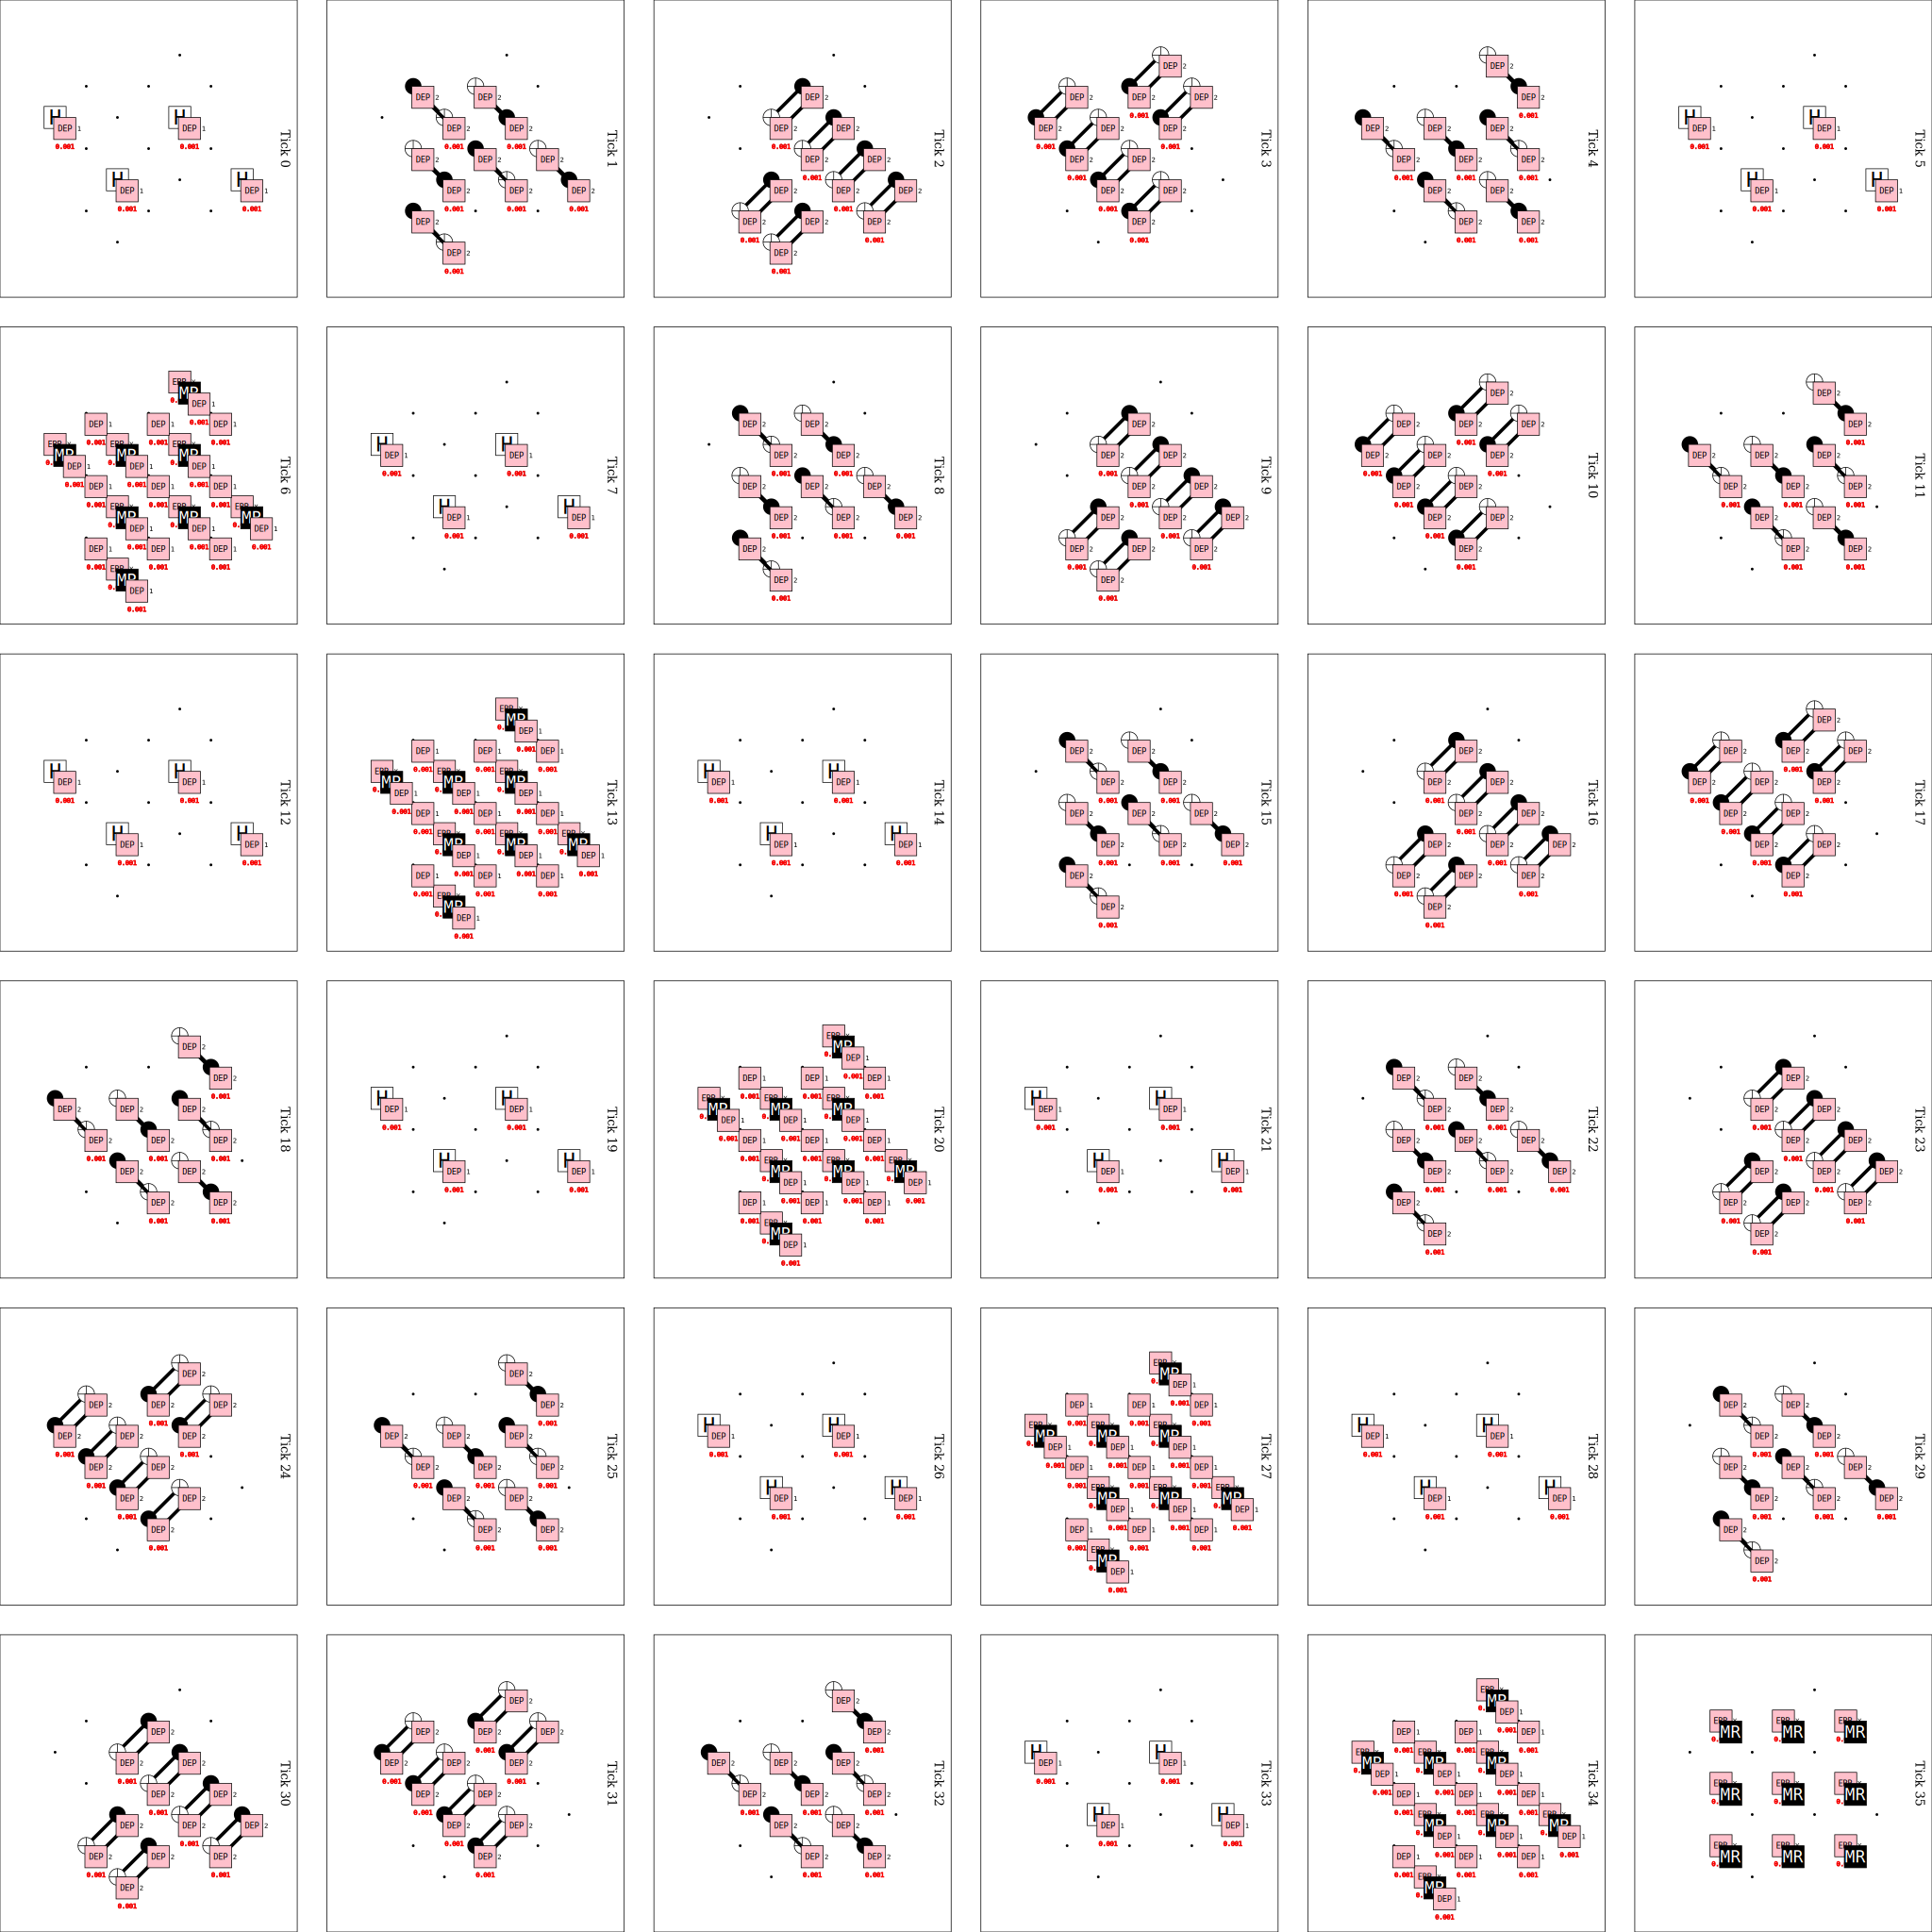

In [133]:
surface_code = SurfaceCode(m=3, n=3, error_rate=0.001)
circuit = surface_code.generate_circuit(rounds=5)
circuit.diagram('timeslice-svg')

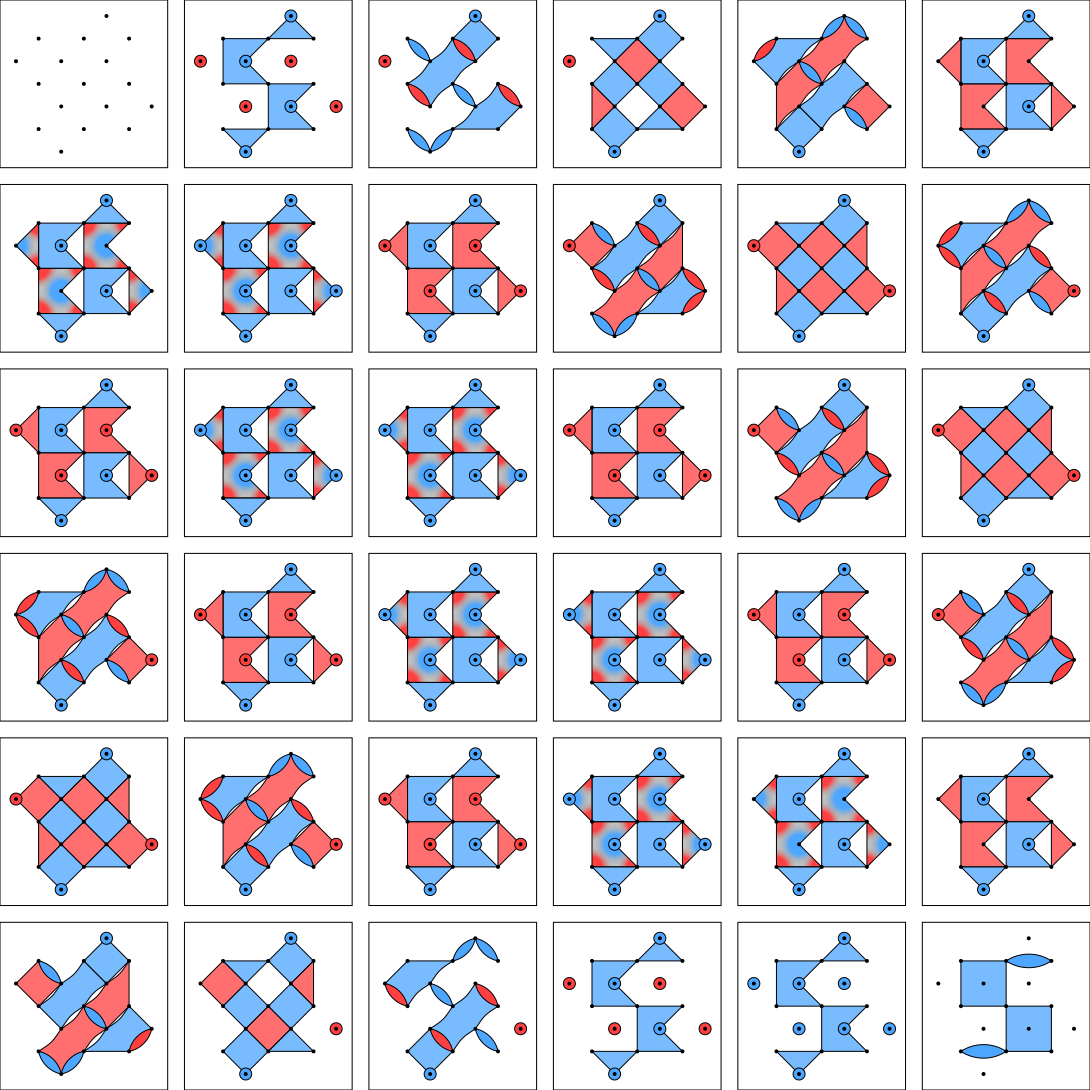

In [134]:
circuit.diagram('detslice-svg')

In [135]:
circuit.diagram('matchgraph-3d')

{"accessors":[{"bufferView":0,"byteOffset":0,"componentType":5126,"count":9,"max":[0,0.400000005960464,0.400000005960464],"min":[0,-0.400000005960464,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":1,"byteOffset":0,"componentType":5126,"count":9,"max":[0.400000005960464,0,0.400000005960464],"min":[-0.400000005960464,0,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":2,"byteOffset":0,"componentType":5126,"count":9,"max":[0.400000005960464,0.400000005960464,0],"min":[-0.400000005960464,-0.400000005960464,0],"name":"circle_loop","type":"VEC3"},{"bufferView":3,"byteOffset":0,"componentType":5126,"count":9,"max":[0,0.400000005960464,0.400000005960464],"min":[0,-0.400000005960464,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":4,"byteOffset":0,"componentType":5126,"count":9,"max":[0.400000005960464,0,0.400000005960464],"min":[-0.400000005960464,0,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":5,"byteOffset":0,"componentType":5126,"count":9,"max":[0.400000005960464,0.400000005960464,0],"min":[-0.400000005960464,-0.400000005960464,0],"name":"circle_loop","type":"VEC3"},{"bufferView":6,"byteOffset":0,"componentType":5126,"count":1894,"max":[24.3704261779785,15.6666669845581,23.7038822174072],"min":[-12.3704252243042,-12.3704252243042,-8.70388221740723],"name":"buf_scattered_lines","type":"VEC3"},{"bufferView":7,"byteOffset":0,"componentType":5126,"count":354,"max":[3,24.3704261779785,23.7038822174072],"min":[-3.66666698455811,-3.66666698455811,-8.70388221740723],"name":"buf_red_scattered_lines","type":"VEC3"}],"asset":{"version":"2.0"},"bufferViews":[{"buffer":0,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":1,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":2,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":3,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":4,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":5,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":6,"byteLength":22728,"byteOffset":0,"name":"buf_scattered_lines","target":34962},{"buffer":7,"byteLength":4248,"byteOffset":0,"name":"buf_red_scattered_lines","target":34962}],"buffers":[{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAM3MzD4AAAAAAAAAAMPQkD7D0JA+AAAAAPIwlrLNzMw+AAAAAMPQkL7D0JA+AAAAAM3MzL7yMBazAAAAAMHQkL7E0JC+AAAAAPLkozHNzMy+AAAAAMbQkD6/0JC+AAAAAM3MzD4AAAAA"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAAAAAADNzMw+w9CQPgAAAADD0JA+zczMPgAAAADyMJayw9CQPgAAAADD0JC+8jAWswAAAADNzMy+xNCQvgAAAADB0JC+zczMvgAAAADy5KMxv9CQvgAAAADG0JA+AAAAAAAAAADNzMw+"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,zczMPgAAAAAAAAAAw9CQPsPQkD4AAAAA8jCWss3MzD4AAAAAw9CQvsPQkD4AAAAAzczMvvIwFrMAAAAAwdCQvsTQkL4AAAAA8uSjMc3MzL4AAAAAxtCQPr/QkL4AAAAAzczMPgAAAAAAAAAA"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAM3MzD4AAAAAAAAAAMPQkD7D0JA+AAAAAPIwlrLNzMw+AAAAAMPQkL7D0JA+AAAAAM3MzL7yMBazAAAAAMHQkL7E0JC+AAAAAPLkozHNzMy+AAAAAMbQkD6/0JC+AAAAAM3MzD4AAAAA"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAAAAAADNzMw+w9CQPgAAAADD0JA+zczMPgAAAADyMJayw9CQPgAAAADD0JC+8jAWswAAAADNzMy+xNCQvgAAAADB0JC+zczMvgAAAADy5KMxv9CQvgAAAADG0JA+AAAAAAAAAADNzMw+"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,zczMPgAAAAAAAAAAw9CQPsPQkD4AAAAA8jCWss3MzD4AAAAAw9CQvsPQkD4AAAAAzczMvvIwFrMAAAAAwdCQvsTQkL4AAAAA8uSjMc3MzL4AAAAAxtCQPr/QkL4AAAAAzczMPgAAAAAAAAAA"},{"byteLength":22728,"name":"buf_scattered_lines","uri":"data:application/octet-stream;base64,AABAQAAAQEAAAAAAAAAQQQAAQMAAAAAAAABAQAAAQEAAAAAAAAAQQQAAQMAAAAAAAAAQQQAAQEAAAEBAhJxdQSTk7L+O1YjAAABAQAAAQEAAAAAAAAAQQQAAEEEAAAAAAABAQAAAQEAAAAAAAABAQAAAQEAAAEBAAABAQAAAQEAAAAAAAABAQAAAQEAA

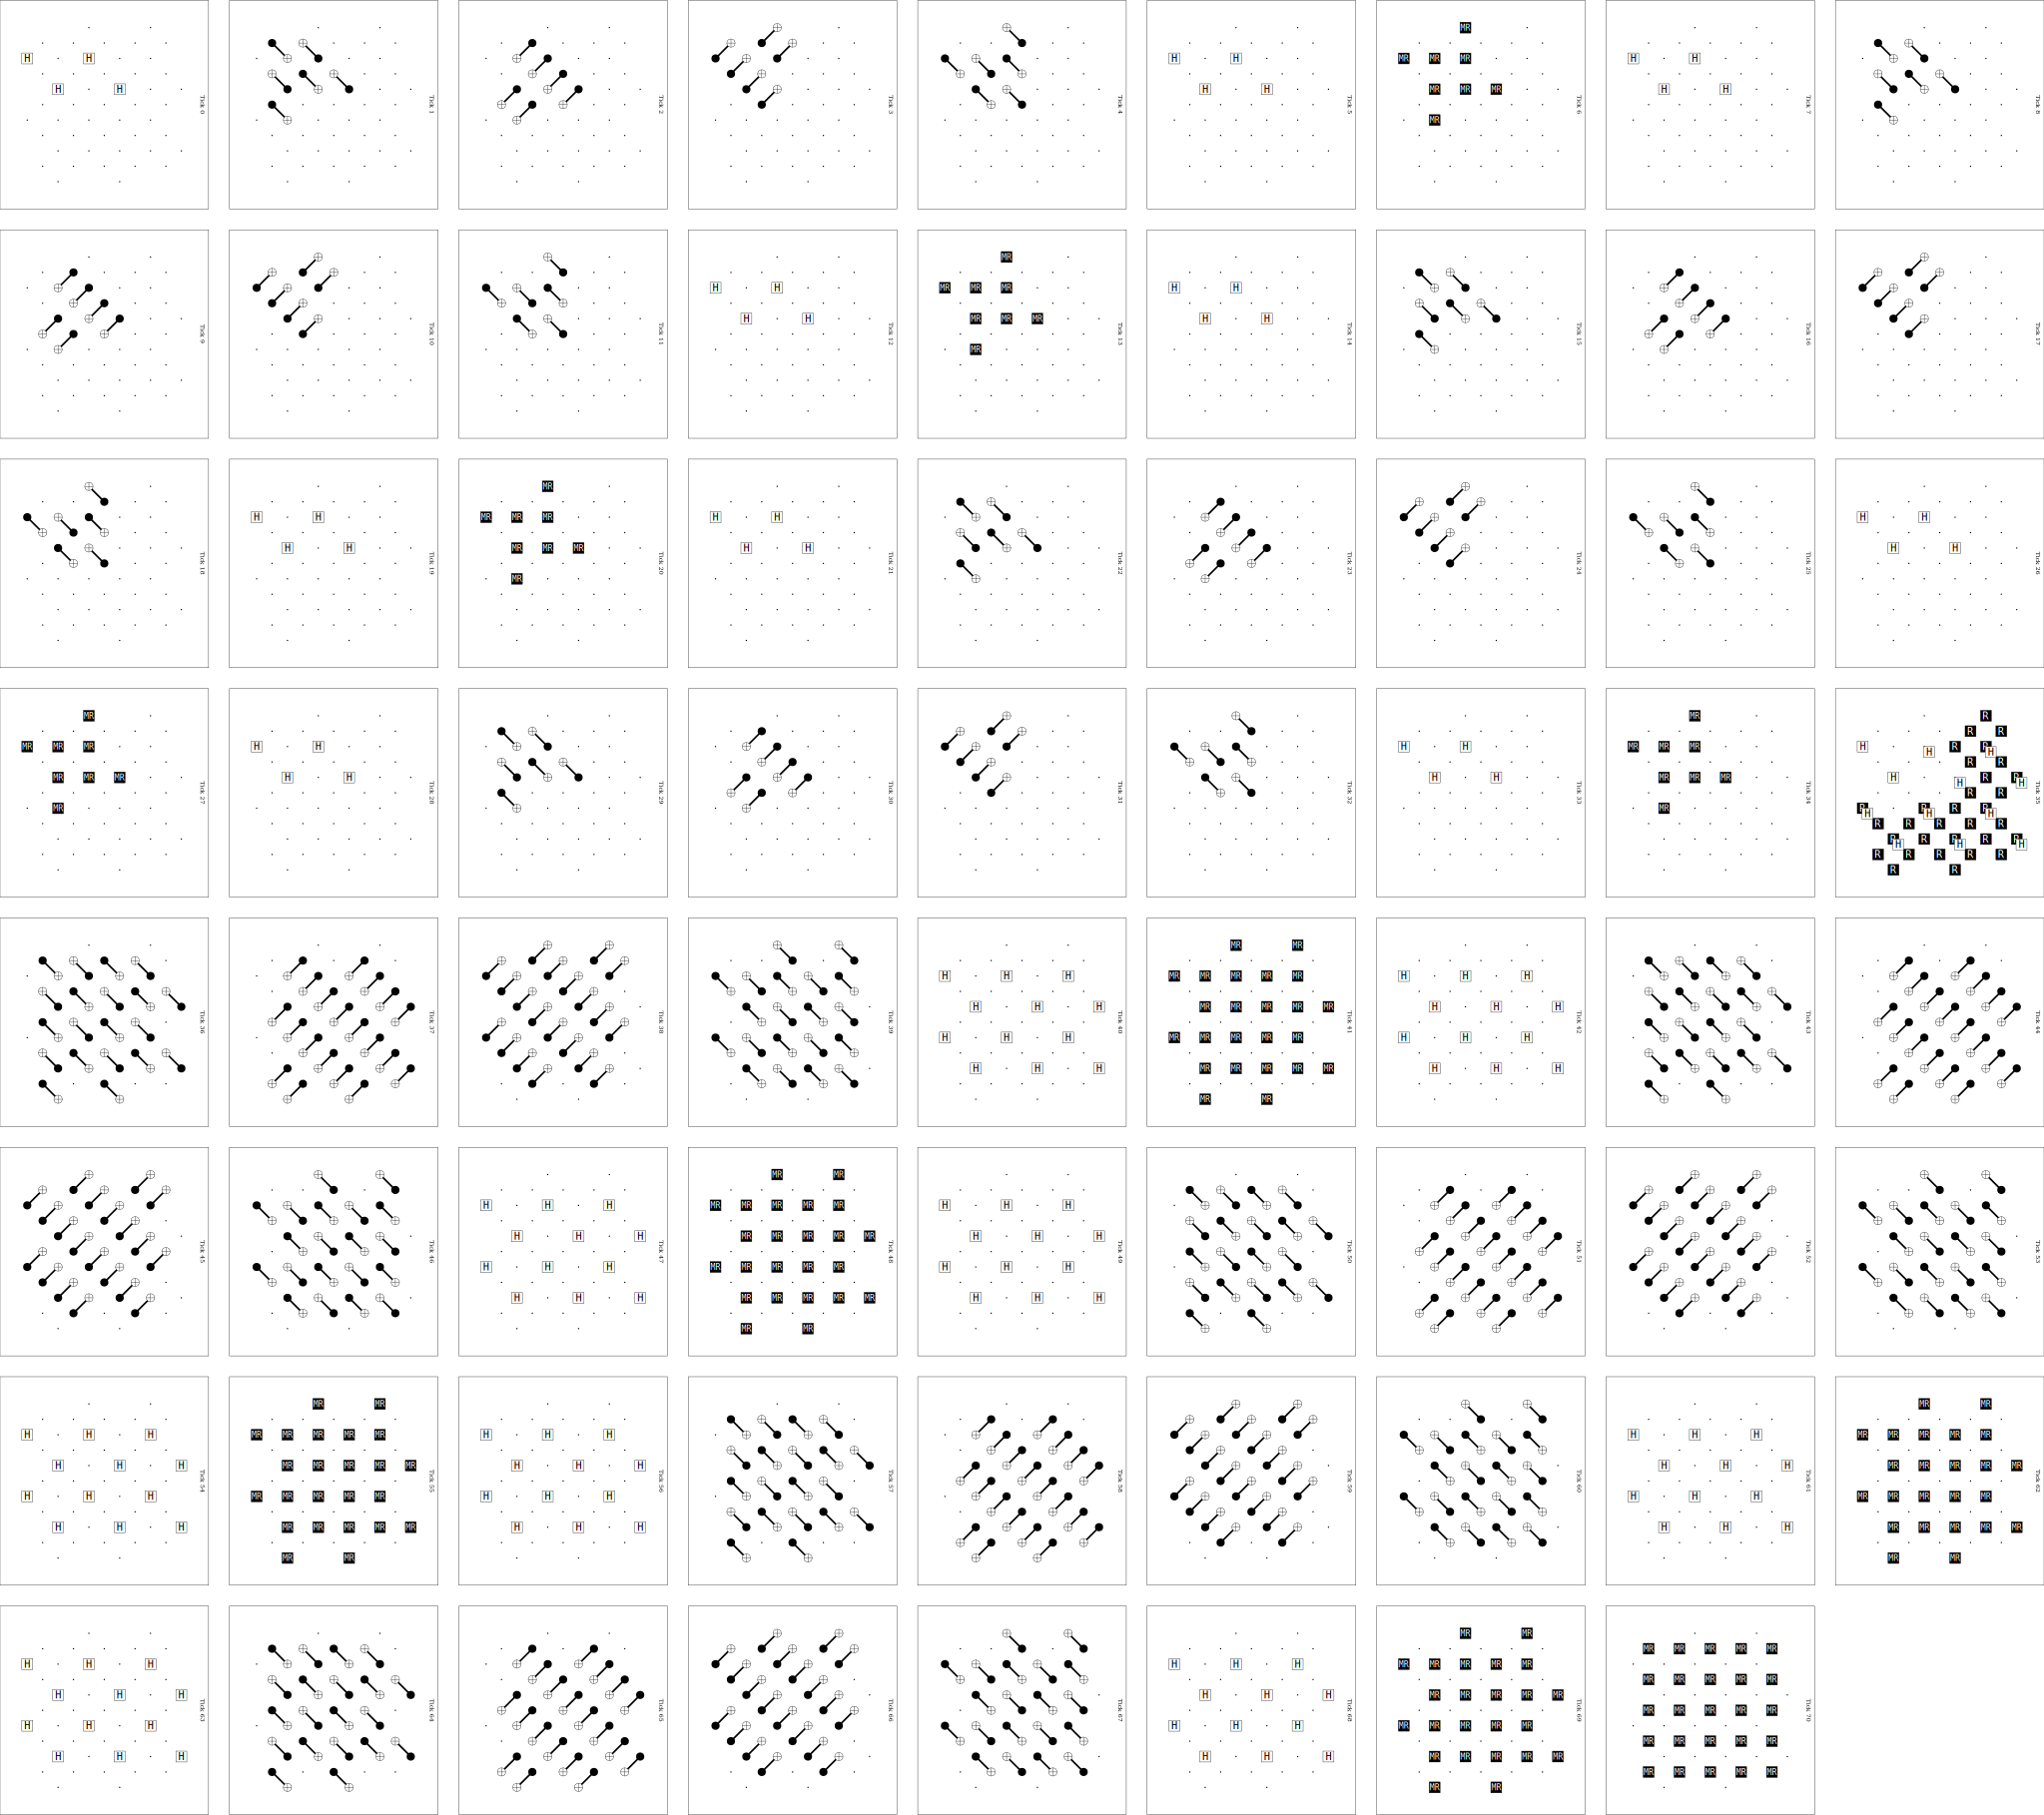

In [136]:
surface_code = SurfaceCode(m=3, n=3, error_rate=0.001)
circuit = surface_code.generate_circuit(rounds=5, if_measure=False)
circuit = surface_code.grow_code(circuit, 5, 10, 5, 5, if_measure=True)
# save circuit to stim file
circuit.to_file("surface_code_expand.stim")
circuit.without_noise().diagram('timeslice-svg')

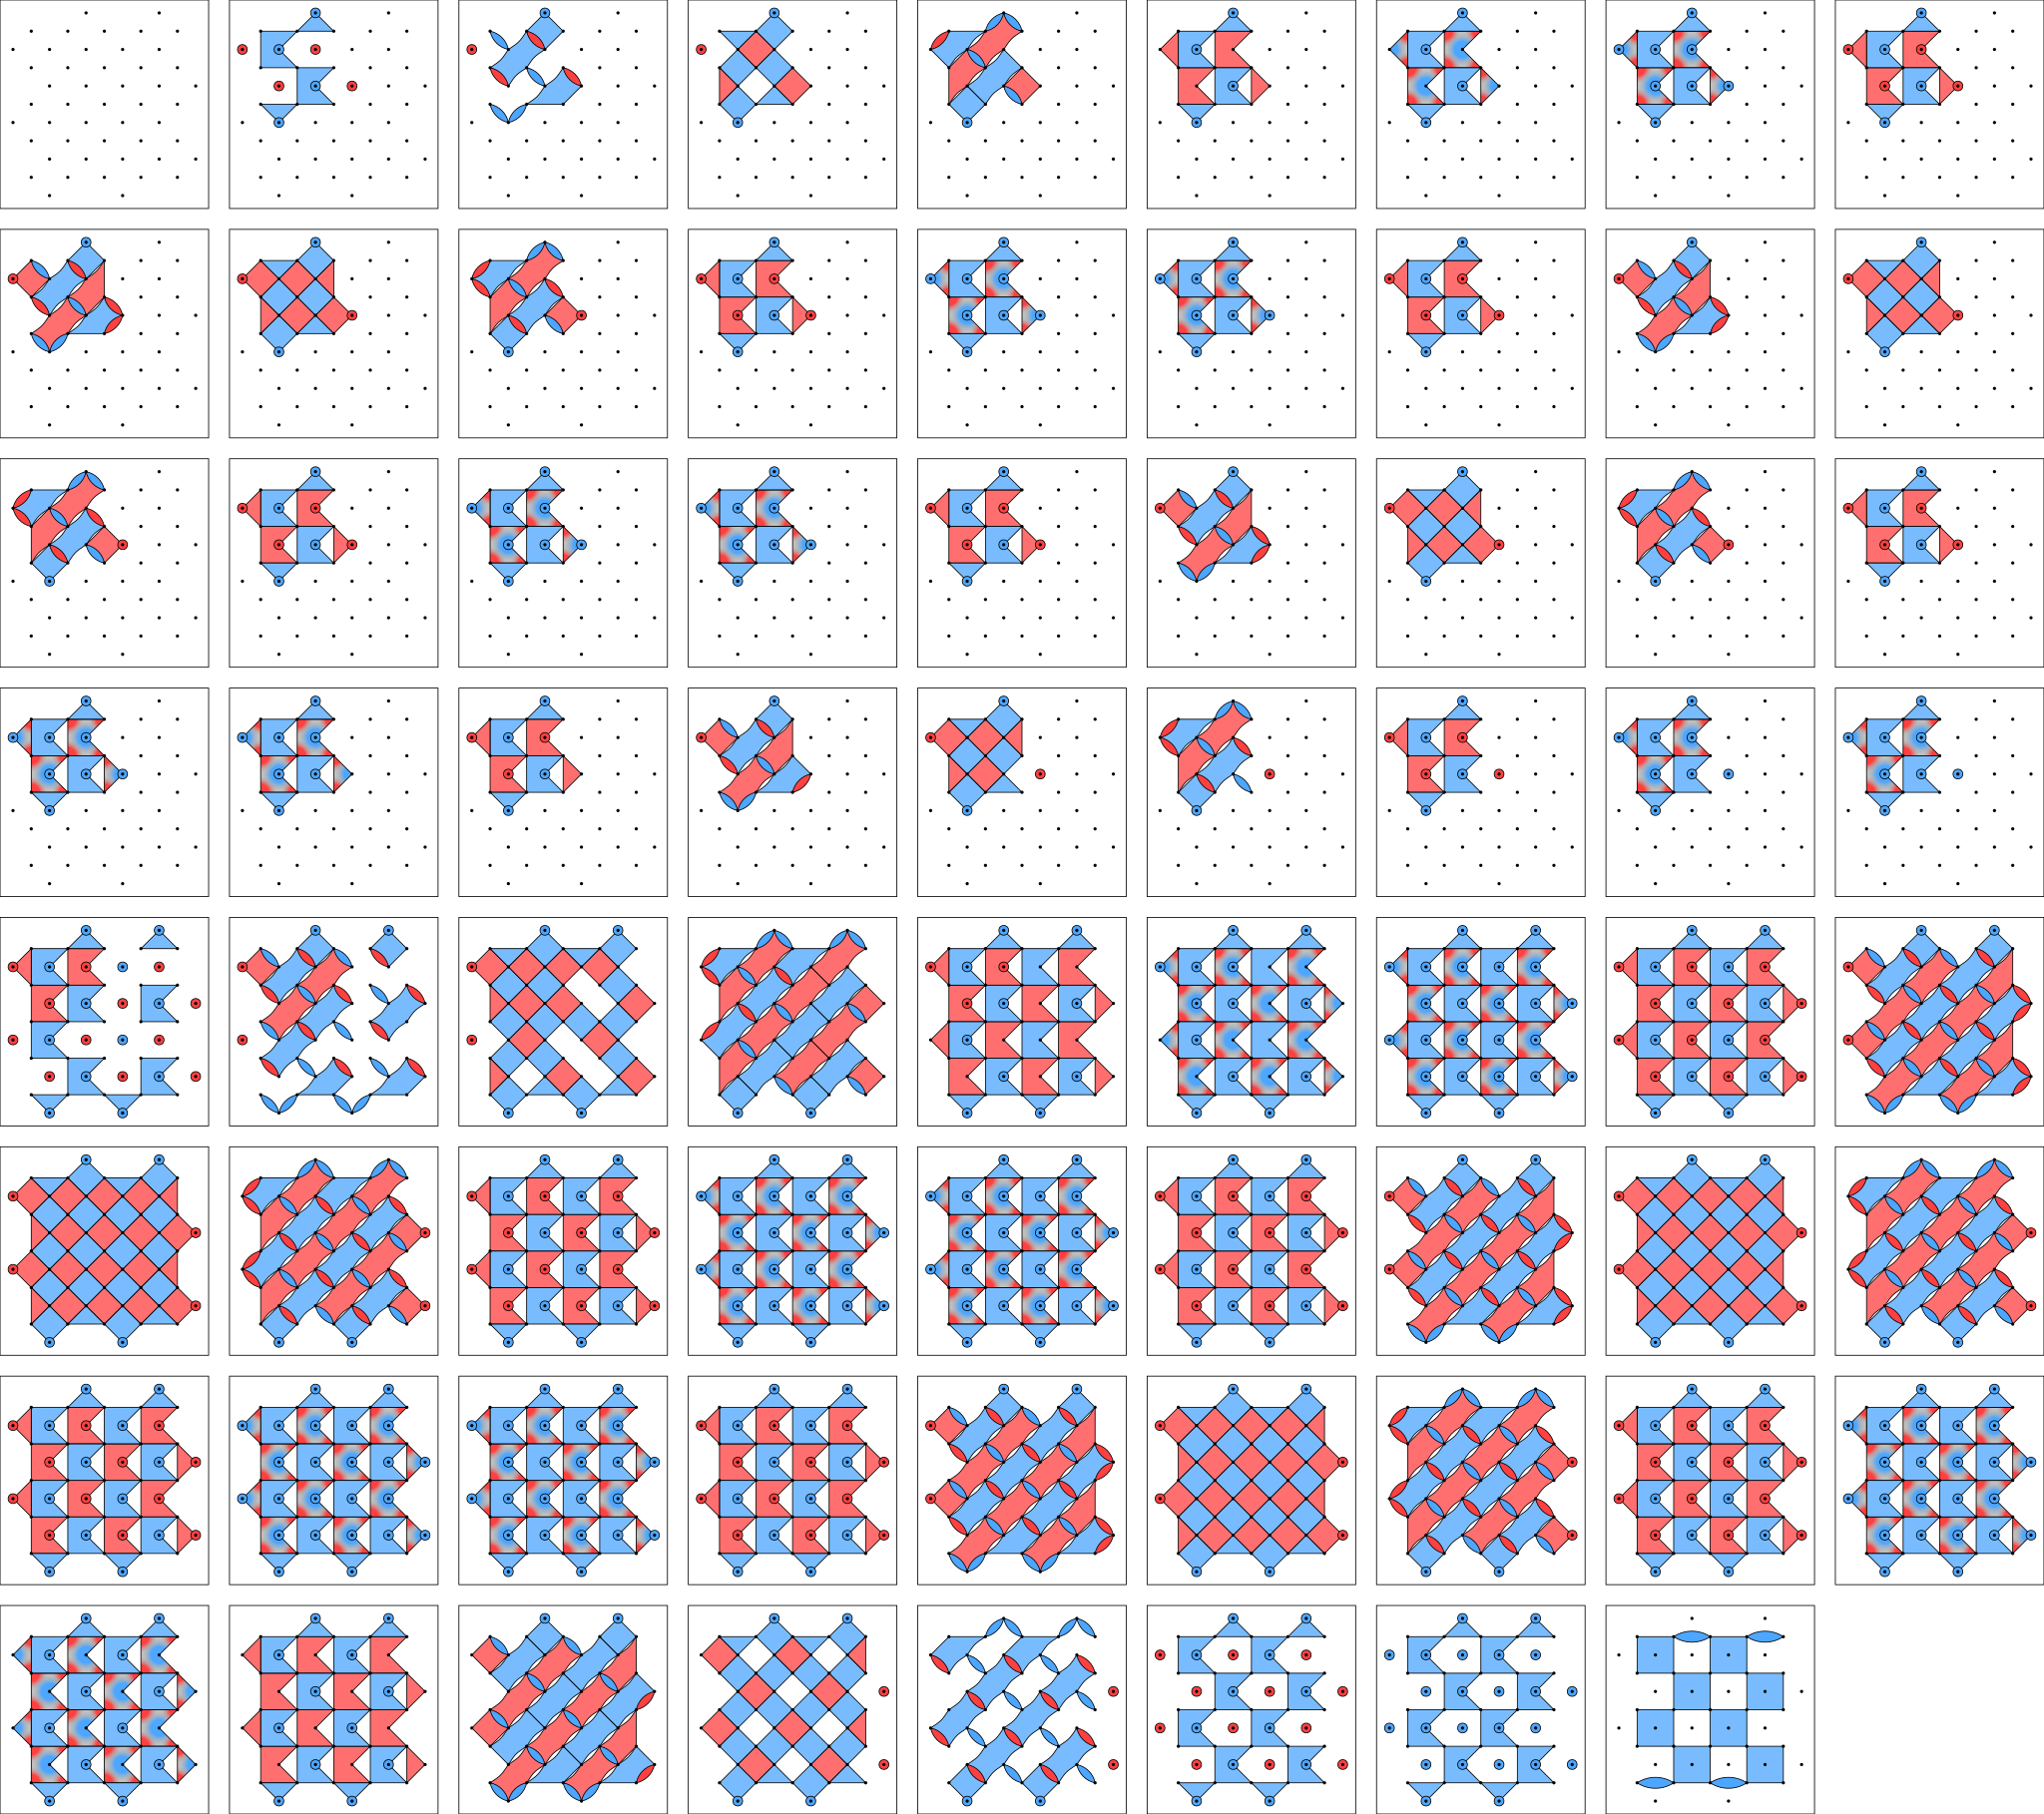

In [137]:
circuit.diagram('detslice-svg')

In [138]:
circuit.diagram('matchgraph-3d')

{"accessors":[{"bufferView":0,"byteOffset":0,"componentType":5126,"count":9,"max":[0,0.400000005960464,0.400000005960464],"min":[0,-0.400000005960464,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":1,"byteOffset":0,"componentType":5126,"count":9,"max":[0.400000005960464,0,0.400000005960464],"min":[-0.400000005960464,0,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":2,"byteOffset":0,"componentType":5126,"count":9,"max":[0.400000005960464,0.400000005960464,0],"min":[-0.400000005960464,-0.400000005960464,0],"name":"circle_loop","type":"VEC3"},{"bufferView":3,"byteOffset":0,"componentType":5126,"count":9,"max":[0,0.400000005960464,0.400000005960464],"min":[0,-0.400000005960464,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":4,"byteOffset":0,"componentType":5126,"count":9,"max":[0.400000005960464,0,0.400000005960464],"min":[-0.400000005960464,0,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":5,"byteOffset":0,"componentType":5126,"count":9,"max":[0.400000005960464,0.400000005960464,0],"min":[-0.400000005960464,-0.400000005960464,0],"name":"circle_loop","type":"VEC3"},{"bufferView":6,"byteOffset":0,"componentType":5126,"count":9182,"max":[36.6225051879883,36.6225051879883,38.4515419006348],"min":[-12.6225051879883,-12.8058071136475,-9.62250518798828],"name":"buf_scattered_lines","type":"VEC3"},{"bufferView":7,"byteOffset":0,"componentType":5126,"count":1100,"max":[3,35.5749282836914,38.4515419006348],"min":[-6.4868335723877,-4.07106781005859,-8.45154190063477],"name":"buf_red_scattered_lines","type":"VEC3"}],"asset":{"version":"2.0"},"bufferViews":[{"buffer":0,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":1,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":2,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":3,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":4,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":5,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":6,"byteLength":110184,"byteOffset":0,"name":"buf_scattered_lines","target":34962},{"buffer":7,"byteLength":13200,"byteOffset":0,"name":"buf_red_scattered_lines","target":34962}],"buffers":[{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAM3MzD4AAAAAAAAAAMPQkD7D0JA+AAAAAPIwlrLNzMw+AAAAAMPQkL7D0JA+AAAAAM3MzL7yMBazAAAAAMHQkL7E0JC+AAAAAPLkozHNzMy+AAAAAMbQkD6/0JC+AAAAAM3MzD4AAAAA"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAAAAAADNzMw+w9CQPgAAAADD0JA+zczMPgAAAADyMJayw9CQPgAAAADD0JC+8jAWswAAAADNzMy+xNCQvgAAAADB0JC+zczMvgAAAADy5KMxv9CQvgAAAADG0JA+AAAAAAAAAADNzMw+"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,zczMPgAAAAAAAAAAw9CQPsPQkD4AAAAA8jCWss3MzD4AAAAAw9CQvsPQkD4AAAAAzczMvvIwFrMAAAAAwdCQvsTQkL4AAAAA8uSjMc3MzL4AAAAAxtCQPr/QkL4AAAAAzczMPgAAAAAAAAAA"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAM3MzD4AAAAAAAAAAMPQkD7D0JA+AAAAAPIwlrLNzMw+AAAAAMPQkL7D0JA+AAAAAM3MzL7yMBazAAAAAMHQkL7E0JC+AAAAAPLkozHNzMy+AAAAAMbQkD6/0JC+AAAAAM3MzD4AAAAA"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAAAAAADNzMw+w9CQPgAAAADD0JA+zczMPgAAAADyMJayw9CQPgAAAADD0JC+8jAWswAAAADNzMy+xNCQvgAAAADB0JC+zczMvgAAAADy5KMxv9CQvgAAAADG0JA+AAAAAAAAAADNzMw+"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,zczMPgAAAAAAAAAAw9CQPsPQkD4AAAAA8jCWss3MzD4AAAAAw9CQvsPQkD4AAAAAzczMvvIwFrMAAAAAwdCQvsTQkL4AAAAA8uSjMc3MzL4AAAAAxtCQPr/QkL4AAAAAzczMPgAAAAAAAAAA"},{"byteLength":110184,"name":"buf_scattered_lines","uri":"data:application/octet-stream;base64,AABAQAAAQEAAAAAAAAAQQQAAQMAAAAAAAABAQAAAQEAAAAAAAAAQQQAAQMAAAAAAAAAQQQAAQEAAAEBAKj7hQAKLOMBWB5vAAABAQAAAQEAAAAAAAAAQQQAAEEEAAAAAAABAQAAAQEAAAAAAAABAQAAAQEAAAEBAAABAQAAAQEAAAAAAAABAQAAAQ

In [148]:
def circuit_to_simulate(T3, T5, t, noise):
    surface_code = SurfaceCode(3, 3, noise)
    if t <= T3:
        circuit = surface_code.generate_circuit(t)
    elif t <= T5:
        circuit = surface_code.generate_circuit(T3, if_measure=False)
        circuit = surface_code.grow_code(circuit, T3, t, 5, 5, if_measure=True)
    else:
        circuit = surface_code.generate_circuit(T3, if_measure=False)
        circuit = surface_code.grow_code(circuit, T3, T5, 5, 5, if_measure=False)
        circuit = surface_code.grow_code(circuit, T5, t, 7, 7, if_measure=True)

    return circuit

T3 = 20
T5 = 40
noise = 0.001

tasks = [
    sinter.Task(
        circuit = circuit_to_simulate(T3, T5, t, noise),
        json_metadata={'t': t}
    )
    for t in range(1, 60, 2)
]

collected_stats: List[sinter.TaskStats] = sinter.collect(
    num_workers=16,
    tasks=tasks,
    decoders=['pymatching'],
    max_shots=1_000_000,
    max_errors=5000,
)

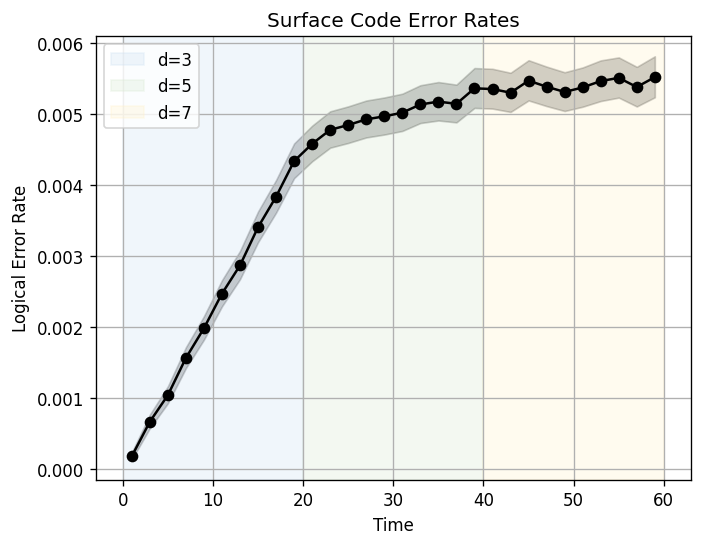

In [150]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: stats.json_metadata['t'],
)
# ax.set_ylim(1e-6, 5e-1)
# ax.set_xlim(5e-4, 1e-2)
ax.set_title("Surface Code Error Rates")
ax.set_xlabel("Time")
ax.set_ylabel("Logical Error Rate")
ax.grid(which='major')
ax.grid(which='minor')
# ax.set_xscale("log")
# ax.set_yscale("log")
for x0, x1, d, color in [
    (0, 20, 3, '#cfe2f3'),
    (20, 40, 5, '#d9ead3'),
    (40, 60, 7, '#fff2cc'),
]:
    ax.axvspan(x0, x1, color=color, alpha=0.3, label=f'd={d}', zorder=0)
ax.legend()
fig.set_dpi(120)  # Show it bigger